# 080. seq2seq language translation

### Encoder-Decoder model


- 영어-한국어 번역

In [1]:
!pip install --upgrade --no-cache-dir gdown

한글 Glove file download

In [2]:
!gdown 1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC

Downloading...
From (original): https://drive.google.com/uc?id=1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC
From (redirected): https://drive.google.com/uc?id=1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC&confirm=t&uuid=70c85c64-f967-4d5e-a592-1c67485f6a67
To: /content/glove.6B.100d.txt
100% 347M/347M [00:03<00:00, 103MB/s]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, Bidirectional

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [4]:
BATCH_SIZE = 64
MAX_VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
LATENT_DIM = 512

## 입력 data list 작성  

### 1. input_texts     : original language 의 input text  


### 2. Teacher Forcing 용 input / target data 생성

- target_texts_inputs  : 1 만큼 offset 된 target language sentence $\rightarrow$ `<sos>....`  
- target_texts  : target language sentence  $\rightarrow$ `.....<eos>`



- data 는 http://www.manythings.org/anki/  (Tab-delimited Bilingual Sentence Pairs) 에서 download  


    - English(input) + `\t` + The Other Language(target) + `\t` + Attribution(기여자) 형식으로 구성
        ex)
        - Hi.	안녕.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee).
        - I like horses.	나는 말을 좋아해.	CC-BY 2.0 (France) Attribution: tatoeba.org #1331062 (Kirschen112) & #8365125 (Eunhee)
        - We had fun with Tom.	우리는 톰과 즐거운 시간을 가졌다.	CC-BY 2.0 (France) Attribution: tatoeba.org #6845055 (CK) & #6845295 (dalgarak)

        
   

In [5]:
file_path = tf.keras.utils.get_file("kor.txt",
             "https://raw.githubusercontent.com/ironmanciti/infran_NLP/main/data/kor.txt")

- teacher forcing 용 input, target 작성

In [6]:
# load in the data
eng_texts = []
kor_inputs = []
kor_targets = []

# load data
for line in open(file_path, 'r', encoding='utf-8'):

    if '\t' not in line:     # \t 가 없는 line 은 skip
        continue

    # input 과 target translation 구분
    english, korean, attribution = line.split('\t')

    # target input 과 output 을 teacher forcing 입력 구성
    input = '<sos> ' + korean
    target = korean + ' <eos>'

    eng_texts.append(english)     # 영어 문장

    kor_inputs.append(input)
    kor_targets.append(target)

len(eng_texts), len(kor_inputs), len(kor_targets)

(3318, 3318, 3318)

In [7]:
print("English :", eng_texts[1100:1110])
print("\nTeacher Forcing Input :", kor_inputs[1100:1110])
print("\nTeacher Forcing Target", kor_targets[1100:1110])

English : ["Don't lie anymore, OK?", "Don't you laugh at me.", 'French is fascinating.', 'French is interesting.', 'French is very useful.', 'He looked quite tired.', 'He was about to speak.', 'He was born in Africa.', 'I called Tom for help.', "I didn't come by taxi."]

Teacher Forcing Input : ['<sos> 거짓말 하지 마세요, 알았죠?', '<sos> 날 비웃지마.', '<sos> 프랑스어는 매력적이야.', '<sos> 프랑스어는 흥미로워.', '<sos> 프랑스어는 아주 유용해.', '<sos> 그사람은 좀 지쳐보였어.', '<sos> 그사람이 말하려고 했어.', '<sos> 그는 아프리카에서 태어났다.', '<sos> 나는 톰에게 도움을 요청했다.', '<sos> 택시로 안 왔어.']

Teacher Forcing Target ['거짓말 하지 마세요, 알았죠? <eos>', '날 비웃지마. <eos>', '프랑스어는 매력적이야. <eos>', '프랑스어는 흥미로워. <eos>', '프랑스어는 아주 유용해. <eos>', '그사람은 좀 지쳐보였어. <eos>', '그사람이 말하려고 했어. <eos>', '그는 아프리카에서 태어났다. <eos>', '나는 톰에게 도움을 요청했다. <eos>', '택시로 안 왔어. <eos>']


## Tokenization

- language 가 2 개 이므로 언어별로 서로 다른 tokenizer 생성. 따라서, 2 개의 word_index 구성

### 영어 input text 의 tokenizer

In [8]:
# 영어 텍스트 데이터를 위한 Tokenizer 객체 생성 (최대 단어 수 지정)
tokenizer_eng = Tokenizer(num_words=MAX_VOCAB_SIZE)

# 영어 텍스트 데이터를 사용하여 토크나이저 학습 수행 (단어 인덱스 구축)
tokenizer_eng.fit_on_texts(eng_texts)

# 영어 텍스트 데이터를 시퀀스로 변환
eng_sequences = tokenizer_eng.texts_to_sequences(eng_texts)

# 1500번째 시퀀스 출력
print(eng_sequences[1500])

# 1500번째 원본 영어 텍스트 출력
print(eng_texts[1500])

# 1500번째 시퀀스의 각 인덱스를 단어로 변환하여 리스트로 출력
[tokenizer_eng.index_word[idx] for idx in eng_sequences[1500]]

[126, 12, 6, 94, 153]
Yesterday was a good day.


['yesterday', 'was', 'a', 'good', 'day']

In [9]:
# 영어 단어를 인덱스로 매핑한 사전 가져오기
word2idx_eng = tokenizer_eng.word_index

# 고유한 입력 토큰 수 출력
print(f'unique input token 수 : {len(word2idx_eng)}')

# 사용할 단어 수 계산 (최대 어휘 크기와 실제 단어 수 + 1 중 작은 값)
num_words_eng = min(MAX_VOCAB_SIZE, len(word2idx_eng) + 1)
print("Input Text 의 단어 수 :", num_words_eng)

# 입력 텍스트의 최대 길이 계산
max_len_eng = max(len(s) for s in eng_sequences)
print("Input Text 의 최대 길이 :", max_len_eng)

unique input token 수 : 2395
Input Text 의 단어 수 : 2396
Input Text 의 최대 길이 : 101


### 한국어 Input Text

### Translation language 의 tokenizer
- 주의 사항 : $<sos>, <eos>$때문에 special character 를 filtering 하면 안됨

In [10]:
# 한국어 텍스트 데이터를 위한 Tokenizer 객체 생성 (최대 단어 수 지정, 필터 비활성화)
tokenizer_kor = Tokenizer(num_words=MAX_VOCAB_SIZE, filters="")

# 한국어 입력 및 타겟 텍스트 데이터를 사용하여 토크나이저 학습 수행 (단어 인덱스 구축)
tokenizer_kor.fit_on_texts(kor_inputs + kor_targets)

# 한국어 입력 텍스트 데이터를 시퀀스로 변환
kor_input_sequences = tokenizer_kor.texts_to_sequences(kor_inputs)

# 한국어 타겟 텍스트 데이터를 시퀀스로 변환
kor_target_sequences = tokenizer_kor.texts_to_sequences(kor_targets)

# 1500번째 한국어 입력 시퀀스 출력
print(kor_input_sequences[1500])

# 1500번째 한국어 타겟 시퀀스 출력
print(kor_target_sequences[1500])

# 1500번째 한국어 입력 시퀀스의 각 인덱스를 단어로 변환하여 리스트로 출력
print([tokenizer_kor.index_word[idx] for idx in kor_input_sequences[1500]])

# 1500번째 한국어 타겟 시퀀스의 각 인덱스를 단어로 변환하여 리스트로 출력
print([tokenizer_kor.index_word[idx] for idx in kor_target_sequences[1500]])

[1, 1164, 87, 2706]
[1164, 87, 2706, 2]
['<sos>', '어제는', '좋은', '날이었다.']
['어제는', '좋은', '날이었다.', '<eos>']


In [11]:
# 한국어 단어를 인덱스로 매핑한 사전 가져오기
word2idx_kor = tokenizer_kor.word_index

# 고유한 출력 토큰 수 출력
print(f'unique output tokens : {len(word2idx_kor)}')

# 사용할 단어 수 계산 (실제 단어 수 + 1)
num_words_kor = len(word2idx_kor) + 1
print("Target 언어의 단어 수 :", num_words_kor)

# 타겟 텍스트의 최대 길이 계산
max_len_kor = max(len(s) for s in kor_target_sequences)
print("Target 언어의 최대 길이 :", max_len_kor)

unique output tokens : 5324
Target 언어의 단어 수 : 5325
Target 언어의 최대 길이 : 90


## sequence padding


### 주의 사항
- encoder 는 thought vector 생성 목적이므로 `pre`(default) 로 padding


- decoder 는 teacher forcing 을 해야하므로 `post` 로 padding

In [12]:
# 영어 시퀀스를 패딩 처리하여 인코더 입력으로 변환 (최대 길이 max_len_eng로 설정)
encoder_inputs = pad_sequences(eng_sequences, maxlen=max_len_eng)
print("encoder input shape :", encoder_inputs.shape)
print("encoder_inputs[0] : ", encoder_inputs[1500])

# 한국어 입력 시퀀스를 패딩 처리하여 디코더 입력으로 변환 (최대 길이 max_len_kor로 설정, 'post' 방식으로 패딩)
decoder_inputs = pad_sequences(kor_input_sequences, maxlen=max_len_kor, padding="post")
print("\ndecoder input shape :", decoder_inputs.shape)
print("decoder_inputs[0] : ", decoder_inputs[1500])

# 한국어 타겟 시퀀스를 패딩 처리하여 디코더 타겟으로 변환 (최대 길이 max_len_kor로 설정, 'post' 방식으로 패딩)
decoder_targets = pad_sequences(kor_target_sequences, maxlen=max_len_kor, padding="post")
print("\ndecoder target shape :", decoder_targets.shape)
print("decoder_targets[0] : ", decoder_targets[1500])

encoder input shape : (3318, 101)
encoder_inputs[0] :  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 126  12   6  94 153]

decoder input shape : (3318, 90)
decoder_inputs[0] :  [   1 1164   87 2706    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]

decoder target shape

## pretrained word embedding 값을 transfer learning

- Embedding layer 의 weight 를 pre-trained model 로 초기화  


- glove.6B 의 EMBEDDING_DIM version 사용  
    - space 로 구분된 text file
    - 첫번째는 word 이고 두번째 이후는 weight vector 값이다


- word index 가 1 부터 시작하므로 0 padding 감안하여 num_words 는 len(word2idx)+1, 혹은 MAX_VOCAB_SIZE 중 작은 것 선택  


- embedding_dict dictionary : key - word, value - embedding_vector

In [13]:
def make_embedding(num_words, embedding_dim, tokenizer, max_vocab_size):
    # 임베딩 사전을 저장할 딕셔너리 초기화
    embeddings_dict = {}

    # GloVe 임베딩 파일 경로 설정
    output = './glove.6B.100d.txt'

    # GloVe 임베딩 파일 열기
    with open(output, encoding="utf8") as f:
        # 파일의 각 줄에 대해 반복
        for i, line in enumerate(f):
            values = line.split()            # 각 줄을 읽어와서 공백으로 분리
            word = values[0]                 # 첫번째 값은 단어
            # 두번째 값부터 마지막 값까지는 해당 단어의 임베딩 벡터 값
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = coefs    # 임베딩 사전에 단어와 임베딩 벡터 저장

    # 임베딩 매트릭스 초기화 (0으로 초기화)
    embedding_matrix = np.zeros((num_words, embedding_dim))

    print("word 갯수 =", num_words)
    print(embedding_matrix.shape)

    # 토크나이저의 단어 인덱스를 사용하여 임베딩 매트릭스 채우기
    for word, i in tokenizer.word_index.items():
        if i < max_vocab_size:
            embedding_vector = embeddings_dict.get(word)  # 해당 단어의 임베딩 벡터 가져오기
            if embedding_vector is not None:              # 해당 단어가 임베딩 사전에 있으면
                embedding_matrix[i] = embedding_vector    # 임베딩 매트릭스에 벡터 값 저장

    return embedding_matrix

In [14]:
# 사용할 단어 수 계산 (최대 어휘 크기와 실제 단어 수 + 1 중 작은 값)
num_words = min(MAX_VOCAB_SIZE, len(word2idx_kor) + 1)
num_words

5325

### embedding layer 작성

- encoder 와 decoder 의 Embedding layer 에 pre-trained embedding weight 를 초기값으로 load

In [15]:
# 임베딩 레이어 생성

# 영어 단어에 대한 임베딩 매트릭스 생성
embedding_matrix = make_embedding(num_words_eng, EMBEDDING_DIM,
                                  tokenizer_eng, MAX_VOCAB_SIZE)

# 임베딩 레이어 생성
embedding_layer = Embedding(num_words_eng, EMBEDDING_DIM,
                            weights=[embedding_matrix], trainable=True)

word 갯수 = 2396
(2396, 100)


## Build model

- encoder 와 decoder 의 embedding, lstm 및 dense layer 를 training 할 목적의 model 작성  

- encoder 는 decoder 에 states [h, c] 만 전달

- prediction 을 위한 model 은 training model 에서 만들어진 layer 들의 weight 를 이용하여 별도 작성  

## Encoder model 작성  

- Training과 Inference State 에서 모두 사용

In [16]:
# 인코더 정의

# 인코더 입력 정의 (최대 길이를 max_len_eng로 설정)
encoder_inputs_ = Input(shape=(max_len_eng, ), name='Encoder_Input')

# 사전 학습된 임베딩 레이어 사용
x = embedding_layer(encoder_inputs_)

# LSTM 레이어를 사용하여 인코더 출력과 상태(hidden state와 cell state) 계산
encoder_outputs, h, c = LSTM(LATENT_DIM, return_state=True)(x)

# 인코더는 hidden state와 cell state만 디코더로 전달 (thought vector)
encoder_states = [h, c]

# 인코더 모델 정의
encoder_model = Model(encoder_inputs_, encoder_states)

# 인코더 모델 요약 출력
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 101)]             0         
                                                                 
 embedding (Embedding)       (None, 101, 100)          239600    
                                                                 
 lstm (LSTM)                 [(None, 512),             1255424   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1495024 (5.70 MB)
Trainable params: 1495024 (5.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Decoder model for Teacher Forcing

- Training stage 에서 만 사용

In [17]:
# 디코더 정의

# 디코더 입력 정의 (최대 길이를 max_len_kor로 설정)
decoder_inputs_ = Input(shape=(max_len_kor,), name="Decoder_Input")

# 디코더의 단어 임베딩은 사전 학습된 벡터를 사용하지 않음
decoder_embedding = Embedding(num_words_kor, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_)

# 교사 강요(Teacher-forcing)를 위한 디코더 LSTM 정의
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
# 초기 상태를 인코더의 [h, c] 상태로 설정
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# 최종 Dense 레이어 정의
decoder_dense = Dense(num_words_kor, activation='softmax', name='Decoder_Output')
decoder_outputs = decoder_dense(decoder_outputs)

# Teacher-forcing 모델 생성
model_teacher_forcing = Model([encoder_inputs_, decoder_inputs_], decoder_outputs)

# 모델 컴파일 및 훈련 설정
model_teacher_forcing.compile(loss='sparse_categorical_crossentropy',
                              optimizer=Adam(0.001), metrics=['accuracy'])

# 모델 요약 출력
model_teacher_forcing.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder_Input (InputLayer)  [(None, 101)]                0         []                            
                                                                                                  
 Decoder_Input (InputLayer)  [(None, 90)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 101, 100)             239600    ['Encoder_Input[0][0]']       
                                                                                                  
 embedding_1 (Embedding)     (None, 90, 100)              532500    ['Decoder_Input[0][0]']       
                                                                                            

- teacher-forcing model 시각화

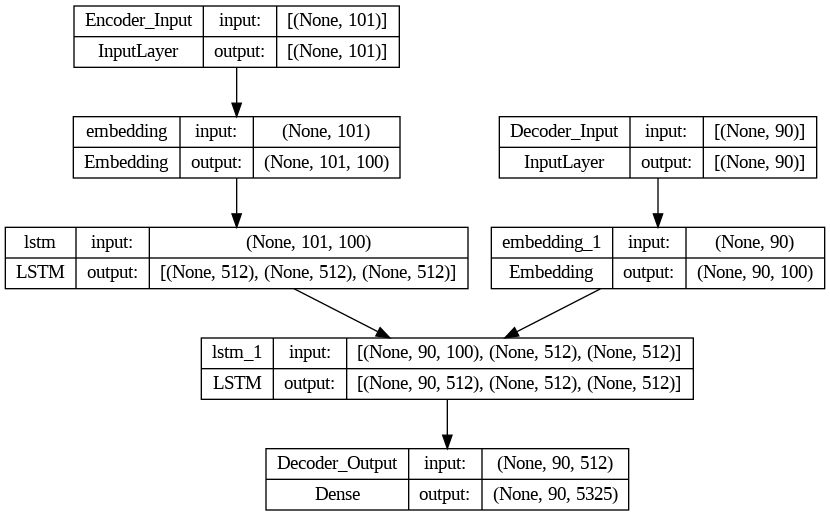

In [18]:
plot_model(model_teacher_forcing, show_shapes=True)

- teacher-forcing model train

In [19]:
history = model_teacher_forcing.fit([encoder_inputs, decoder_inputs],
                                    decoder_targets, batch_size=BATCH_SIZE,
                                    epochs=70, validation_split=0.2)

Epoch 1/100
42/42 [==============================] - 19s 300ms/step - loss: 1.4716 - accuracy: 0.9259 - val_loss: 0.7082 - val_accuracy: 0.9196
Epoch 2/100
42/42 [==============================] - 8s 186ms/step - loss: 0.3474 - accuracy: 0.9527 - val_loss: 0.6826 - val_accuracy: 0.9207
Epoch 3/100
42/42 [==============================] - 6s 132ms/step - loss: 0.3325 - accuracy: 0.9534 - val_loss: 0.6945 - val_accuracy: 0.9210
Epoch 4/100
42/42 [==============================] - 5s 125ms/step - loss: 0.3210 - accuracy: 0.9544 - val_loss: 0.6785 - val_accuracy: 0.9218
Epoch 5/100
42/42 [==============================] - 5s 110ms/step - loss: 0.3098 - accuracy: 0.9557 - val_loss: 0.6873 - val_accuracy: 0.9217
Epoch 6/100
42/42 [==============================] - 4s 105ms/step - loss: 0.2981 - accuracy: 0.9575 - val_loss: 0.6724 - val_accuracy: 0.9236
Epoch 7/100
42/42 [==============================] - 5s 112ms/step - loss: 0.2872 - accuracy: 0.9593 - val_loss: 0.6951 - val_accuracy: 0.923

- accuracy, loss 시각화

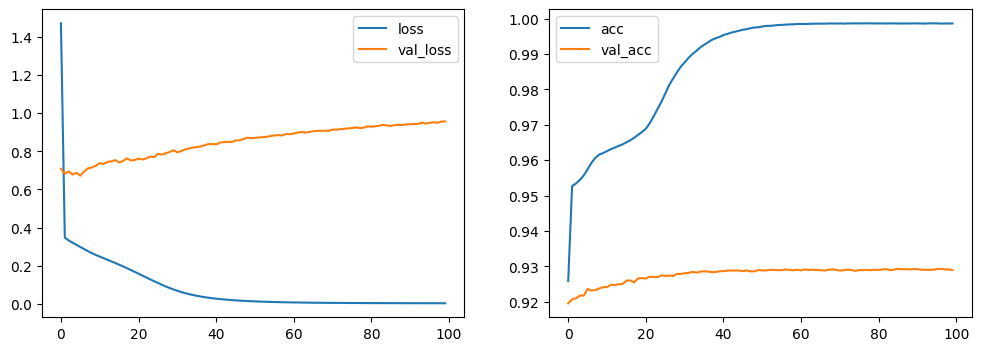

In [20]:
# plot some data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.legend()

# accuracies
ax2.plot(history.history['accuracy'], label='acc')
ax2.plot(history.history['val_accuracy'], label='val_acc')
ax2.legend()
plt.show()

- save model

In [21]:
model_teacher_forcing.save('seq2seq_translation.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Make Predictions - Inference phase

- prediction 을 위한 별도의 decoder model 작성  

- 별로 training 없이 앞에서 train 된 weights 를 모두 재사용 한다.

- decoder 는 encoder 와 분리되어 구성

In [22]:
# 추론(Inference)용 디코더 정의

# 디코더 LSTM의 hidden state 입력 정의 (512 차원)
decoder_state_input_h = Input(shape=(512,), name='Decoder_hidden_h')

# 디코더 LSTM의 cell state 입력 정의 (512 차원)
decoder_state_input_c = Input(shape=(512,), name='Decoder_hidden_c')

# 디코더 상태 입력 리스트 생성
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 디코더의 단일 단어 입력 정의 (1차원)
decoder_inputs_single = Input(shape=(1,), name='Decoder_input')

# 단일 단어 입력을 임베딩 벡터로 변환
x = decoder_embedding(decoder_inputs_single)

# 출력과 hidden states 저장
decoder_outputs, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)

# 새로운 디코더 상태 리스트 생성
decoder_states = [h, c]

# 디코더 출력에 Dense 레이어 적용
decoder_outputs = decoder_dense(decoder_outputs)

# 추론용 디코더 모델 생성
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,    # 디코더 입력과 상태를 입력으로 받음
    [decoder_outputs] + decoder_states                  # 디코더 출력과 상태를 출력으로 반환
)

# 추론용 디코더 모델 요약 출력
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Decoder_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     multiple                     532500    ['Decoder_input[0][0]']       
                                                                                                  
 Decoder_hidden_h (InputLay  [(None, 512)]                0         []                            
 er)                                                                                              
                                                                                                  
 Decoder_hidden_c (InputLay  [(None, 512)]                0         []                      

- inference 용 decoder model 시각화

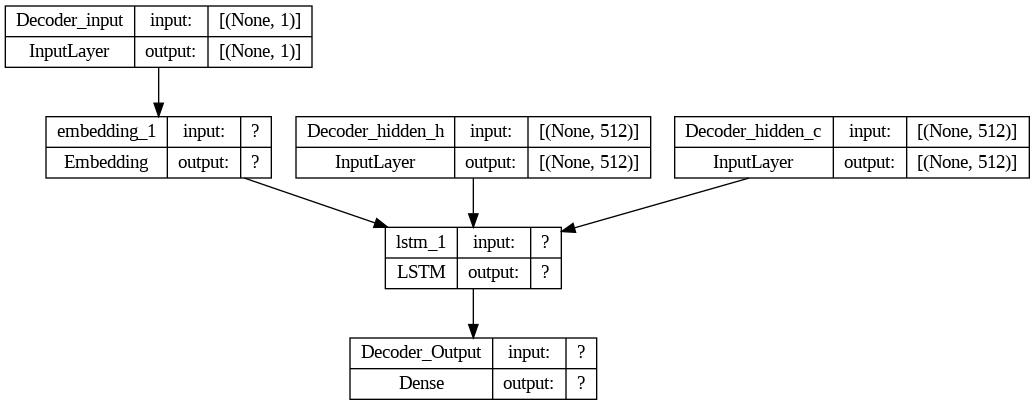

In [23]:
plot_model(decoder_model, show_shapes=True)

예측하는 동안 index를 단어를 되돌리기 위한 reverse word2idx dictionary 작성

### Translation Inference

In [24]:
def decode_sequence(input_seq):
    # 인코더 모델을 이용하여 입력을 상태 벡터로 인코딩
    states_value = encoder_model.predict(input_seq, verbose=0)

    # 길이 1의 빈 타겟 시퀀스 생성
    target_seq = np.zeros((1, 1))

    # 타겟 시퀀스의 첫 번째 단어를 시작 토큰(<sos>)으로 설정
    target_seq[0, 0] = word2idx_kor['<sos>']

    # 종료 토큰(<eos>)이 디코딩에서 생성되면 루프 종료
    eos = word2idx_kor['<eos>']

    # 번역문 생성
    output_sentence = []
    for _ in range(max_len_kor):
        # 디코더 모델을 이용하여 다음 단어 예측 및 상태 업데이트
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # argmax로 가장 확률 높은 단어 선택 (탐욕적 선택)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:  # 종료 토큰(<eos>)이 생성되면 루프 종료
            break

        if idx > 0:  # idx 0은 zero padding된 시퀀스이므로 무시
            word = tokenizer_kor.index_word[idx]
            output_sentence.append(word)

        # 생성된 단어를 디코더의 다음 입력으로 사용
        target_seq[0, 0] = idx

        # 상태 업데이트
        states_value = [h, c]

    return ' '.join(output_sentence)

# 번역 테스트
for _ in range(5):
    i = np.random.choice(len(eng_texts))
    input_seq = encoder_inputs[i:i+1]

    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', eng_texts[i])
    print('Translation:', translation)

-
Input: I'm sorry.
Translation: 미안해요.
-
Input: I'm just telling you what I heard.
Translation: 나는 내가 들은 걸 너에게 말해주는 것뿐이다.
-
Input: I agree.
Translation: 동의해.
-
Input: Tom and Mary are in the same boat.
Translation: 톰과 마리는 같은 배를 탔다.
-
Input: Rabbits are extremely social animals.
Translation: 토끼는 사회적 동물이야.


### 임의의 영어 입력을 처리하는 영한 번역 함수

In [25]:
def Eng_Kor_translation(txt):
    # 입력된 영어 텍스트를 시퀀스로 변환
    input_sequence = tokenizer_eng.texts_to_sequences([txt])

    # 시퀀스를 패딩 처리하여 인코더 입력으로 변환 (최대 길이를 max_len_eng로 설정)
    encoder_input = pad_sequences(input_sequence, maxlen=max_len_eng)

    # 인코더 입력을 디코더 시퀀스로 변환하여 번역 결과 반환
    return decode_sequence(encoder_input)

In [26]:
test_text = [
       "Your lips are red.",
       "French is interesting.",
       "I like you.",
       "Let's go to home."
]
for text in test_text:
    translation = Eng_Kor_translation(text)
    print('----')
    print('Input:', text)
    print('Translation:', translation)

----
Input: Your lips are red.
Translation: 네 입술 빨개.
----
Input: French is interesting.
Translation: 프랑스어는 흥미로워.
----
Input: I like you.
Translation: 나는 부러워.
----
Input: Let's go to home.
Translation: 집에 가고
